In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import recall_score, confusion_matrix, precision_score, f1_score, accuracy_score, classification_report
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
# from sklearn.tree import DecisionTreeRegressor
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import BaggingClassifier
from imblearn.ensemble import BalancedBaggingClassifier
from sklearn.feature_selection import SequentialFeatureSelector
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler
from sklearn.model_selection import cross_val_score, StratifiedKFold

import torch
import torch.nn as nn
import torch.optim as optim

In [2]:
df = pd.read_csv(r"healthcare-dataset-stroke-data.csv")
df.head()

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1


In [3]:
df.shape

(5110, 12)

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5110 entries, 0 to 5109
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 5110 non-null   int64  
 1   gender             5110 non-null   object 
 2   age                5110 non-null   float64
 3   hypertension       5110 non-null   int64  
 4   heart_disease      5110 non-null   int64  
 5   ever_married       5110 non-null   object 
 6   work_type          5110 non-null   object 
 7   Residence_type     5110 non-null   object 
 8   avg_glucose_level  5110 non-null   float64
 9   bmi                4909 non-null   float64
 10  smoking_status     5110 non-null   object 
 11  stroke             5110 non-null   int64  
dtypes: float64(3), int64(4), object(5)
memory usage: 479.2+ KB


In [5]:
df.isna().sum()

id                     0
gender                 0
age                    0
hypertension           0
heart_disease          0
ever_married           0
work_type              0
Residence_type         0
avg_glucose_level      0
bmi                  201
smoking_status         0
stroke                 0
dtype: int64

### Residence_type has only two unique values, but work_type has 5 unique values. We will keep this in mind for how we decide to transform these columns' data from objects into ints

In [6]:
df["Residence_type"].unique()

array(['Urban', 'Rural'], dtype=object)

In [7]:
df["work_type"].unique()

array(['Private', 'Self-employed', 'Govt_job', 'children', 'Never_worked'],
      dtype=object)

In [8]:
df["smoking_status"].unique()

array(['formerly smoked', 'never smoked', 'smokes', 'Unknown'],
      dtype=object)

## Exploratory Data Analysis (EDA)

### Let's perform Data Visualization and analyze correlations between features in the Data Set

In [9]:
visual_df = df.copy()

In [10]:
visual_df[visual_df["gender"] == "Other"]

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
3116,56156,Other,26.0,0,0,No,Private,Rural,143.33,22.4,formerly smoked,0


In [11]:
visual_df = visual_df[visual_df["gender"] != "Other"]

### make the 1's and 0's in the binary columns into actually readable labels for data visualization

In [12]:
visual_df['Heart Disease'] = visual_df['heart_disease'].apply(lambda x: 'Yes' if x == 1 else 'No')

In [13]:
visual_df['Hypertension'] = visual_df['hypertension'].apply(lambda x: 'Hypertension' if x == 1 else 'No Hypertension')

In [14]:
visual_df['written stroke'] = visual_df['stroke'].apply(lambda x: 'stroke' if x == 1 else 'no stroke')

### create a subset of visual_df that contains non-missing values so we can examine bmi's correlation with other features in the dataset (remember "bmi" contains 200+ missing values)

In [15]:
visual_complete_df = visual_df.dropna(subset=['bmi'])

In [16]:
visual_df.head()

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke,Heart Disease,Hypertension,written stroke
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1,Yes,No Hypertension,stroke
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1,No,No Hypertension,stroke
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1,Yes,No Hypertension,stroke
3,60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1,No,No Hypertension,stroke
4,1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1,No,Hypertension,stroke


### no stroke = 0, stroke = 1

In [17]:
num_stroke = visual_df["stroke"].value_counts()
num_stroke.values

array([4860,  249], dtype=int64)

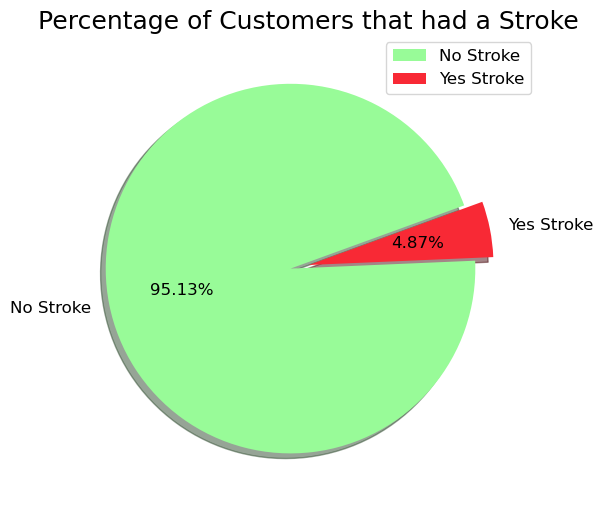

In [18]:
data = num_stroke.values
labels = ["No Stroke", "Yes Stroke"]

c = ["palegreen","#F82935"] 
e = [0.1, 0]

plt.figure(figsize=(8,6))  
plt.title("Percentage of Customers that had a Stroke", fontsize = 18, 
          color = 'black', pad=1);
plt.pie(data, labels=labels, colors=c, autopct = '%.2f%%', explode=e, shadow = True, 
        startangle = 20, textprops={'fontsize': 12})
plt.legend(loc = "best", fontsize = 12);

Note: The dataset is highly imbalanced. We'll need to use imbalanced data techniques before applying machine learning algorithms

In [19]:
stroke_vs_work = pd.crosstab(visual_df["work_type"], visual_df["written stroke"]).sort_values(by="stroke", ascending=True)
stroke_vs_work

written stroke,no stroke,stroke
work_type,,
Never_worked,22,0
children,685,2
Govt_job,624,33
Self-employed,754,65
Private,2775,149


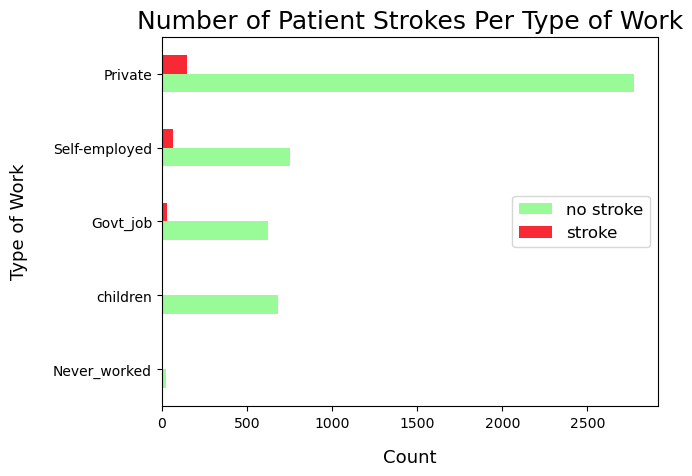

In [20]:
stroke_vs_work.plot(kind = "barh", color = ["palegreen","#F82935"] )
plt.title("Number of Patient Strokes Per Type of Work", fontsize = 18, color = "black");
plt.xlabel("Count", labelpad = 13, fontsize = 13)
plt.yticks(rotation = 0)
plt.ylabel("Type of Work", labelpad = 18, fontsize = 13)
plt.legend(loc = "right", fontsize = 12)
plt.show;

In [21]:
stroke_vs_smoke = pd.crosstab(visual_df["smoking_status"], visual_df["written stroke"])
stroke_vs_smoke["Density"] = stroke_vs_smoke["stroke"] / (stroke_vs_smoke["stroke"] + stroke_vs_smoke["no stroke"])
stroke_vs_smoke

written stroke,no stroke,stroke,Density
smoking_status,,,
Unknown,1497,47,0.030440
formerly smoked,814,70,0.079186
never smoked,1802,90,0.047569
smokes,747,42,0.053232


C:\Users\bprit\AppData\Local\Temp\ipykernel_28160\3084547990.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=stroke_vs_smoke.index, y=densities, linewidth=0.5, palette = colors)   #linewidth makes the bars skinnier
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


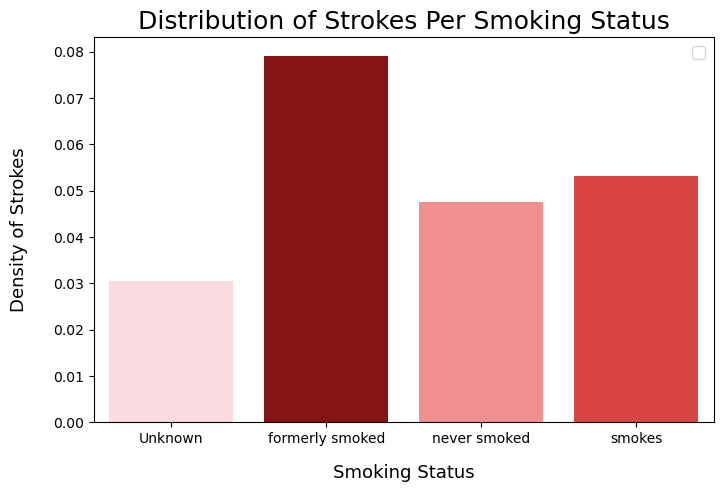

In [22]:
densities = stroke_vs_smoke["Density"].values
colors = [ "#FFD6DB",  "#990000", "#FF7F7F", "#F12C2C"]

plt.figure(figsize=(8, 5))
sns.barplot(x=stroke_vs_smoke.index, y=densities, linewidth=0.5, palette = colors)   #linewidth makes the bars skinnier
plt.title("Distribution of Strokes Per Smoking Status", fontsize = 18, color = "black")
plt.xlabel("Smoking Status", labelpad = 13, fontsize = 13)
plt.ylabel("Density of Strokes", labelpad = 18, fontsize = 13)
plt.legend(loc = "best", fontsize = 12)
plt.show;

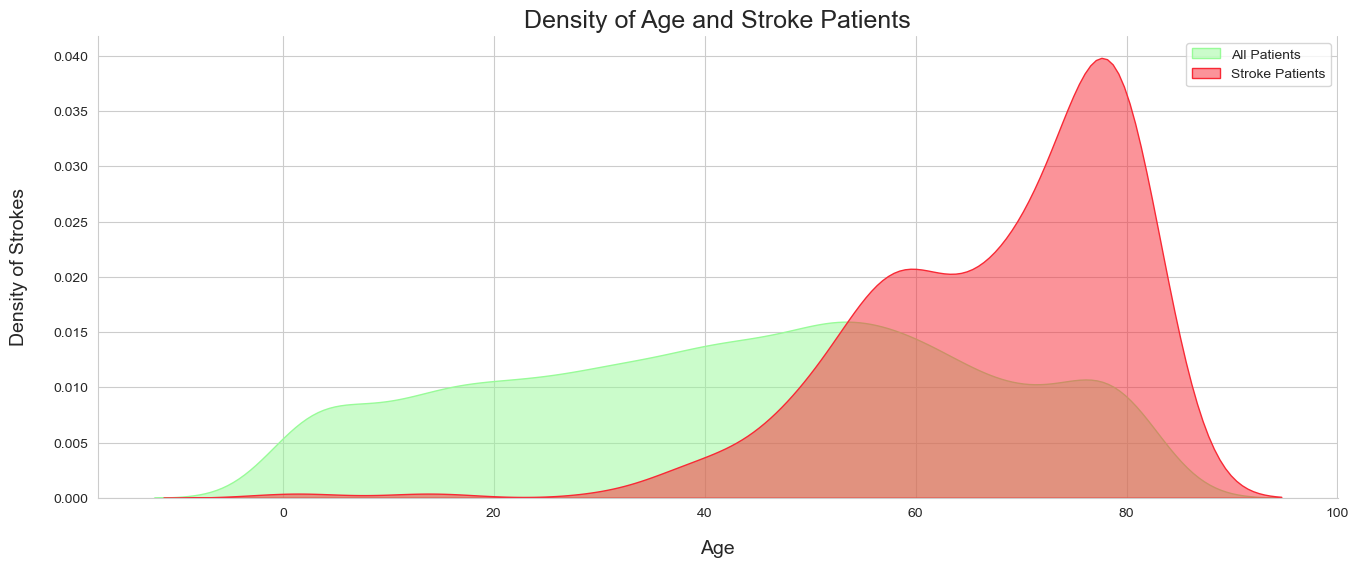

In [23]:
# Filter visual_df to include only rows where stroke patients are visible
stroke_df = visual_df[visual_df["written stroke"] == "stroke"]

sns.set_style("whitegrid")
plt.figure(figsize=(16, 6))

#density of age for all patients
sns.kdeplot(data=visual_df, x='age', fill=True, color='palegreen', alpha=0.5, label='All Patients')

# Density of stroke patients per age
sns.kdeplot(data=stroke_df, x='age', fill=True, color='#F82935', alpha=0.5, label='Stroke Patients')

sns.despine()

plt.title('Density of Age and Stroke Patients', fontsize=18)
plt.xlabel('Age', labelpad = 14, fontsize=14)
plt.ylabel('Density of Strokes', labelpad = 18, fontsize=14)
plt.legend()

# Show the plot
plt.show();


In [24]:
visual_df["hypertension"].value_counts()

hypertension
0    4611
1     498
Name: count, dtype: int64

In [25]:
visual_df['Hypertension'] = visual_df['hypertension'].apply(lambda x: 'Hypertension' if x == 1 else 'No Hypertension')

<Figure size 1000x600 with 0 Axes>

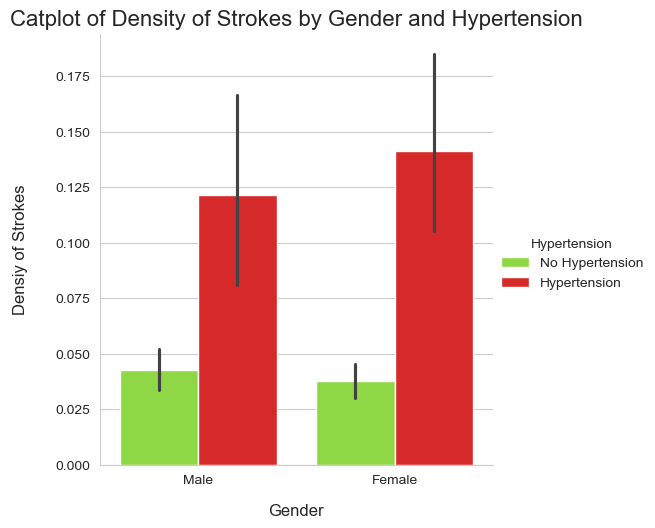

In [26]:
custom_colors = ["#8FF12C", "#F30C0C"]
plt.figure(figsize=(10, 6))
sns.catplot(x="gender", y="stroke", hue="Hypertension", palette=custom_colors, kind="bar", data=visual_df)
plt.title('Catplot of Density of Strokes by Gender and Hypertension', fontsize=16)
plt.xlabel('Gender', labelpad = 12, fontsize=12)
plt.ylabel('Densiy of Strokes', labelpad = 20, fontsize=12)
plt.show();

In [27]:
visual_df['heart_disease'].value_counts()

heart_disease
0    4833
1     276
Name: count, dtype: int64

<Figure size 1000x600 with 0 Axes>

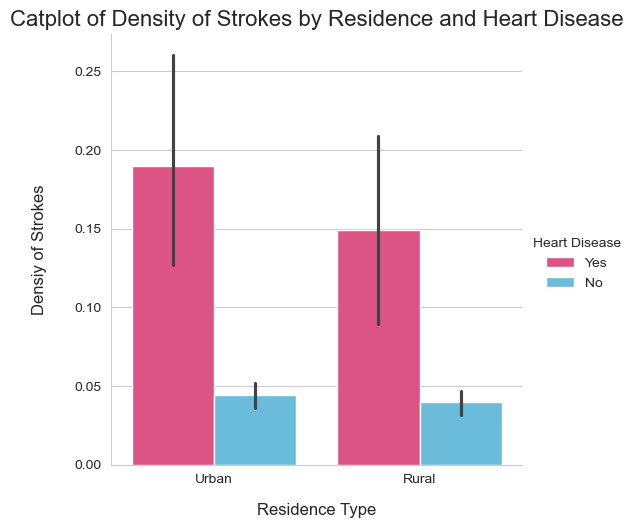

In [28]:
custom_colors = ["#F23E7D", "#59C4EC"]
plt.figure(figsize=(10, 6));
sns.catplot(x="Residence_type", y="stroke", hue="Heart Disease", palette=custom_colors, kind="bar", data=visual_df)
plt.title('Catplot of Density of Strokes by Residence and Heart Disease', fontsize=16)
plt.xlabel('Residence Type', labelpad = 12, fontsize=12)
plt.ylabel('Densiy of Strokes', labelpad = 20, fontsize=12);
plt.show();

### Let's now use the visual_complete_df (which contains all rows in visual_df with no missing values) to analyze the "bmi" feature

In [29]:
visual_complete_df.head()

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke,Heart Disease,Hypertension,written stroke
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1,Yes,No Hypertension,stroke
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1,Yes,No Hypertension,stroke
3,60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1,No,No Hypertension,stroke
4,1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1,No,Hypertension,stroke
5,56669,Male,81.0,0,0,Yes,Private,Urban,186.21,29.0,formerly smoked,1,No,No Hypertension,stroke


In [30]:
# Calculate the probability of stroke based on BMI ranges
custom_bins = [10, 18.5, 24.9, 29.9, 34.9, 39.9, 100]
# Create bins based on the custom edges
bmi_ranges = pd.cut(visual_complete_df['bmi'], bins=custom_bins)

# Count the number of people with stroke in each BMI bin
stroke_counts = visual_complete_df[visual_complete_df['stroke'] == 1].groupby(bmi_ranges)['stroke'].count()

print(stroke_counts)

# Calculate the total number of people in each BMI bin
total_counts = visual_complete_df.groupby(bmi_ranges)['stroke'].count()
print(total_counts)

# Calculate the ratio of people with stroke in each bin
stroke_ratios = stroke_counts / total_counts

bmi
(10.0, 18.5]      1
(18.5, 24.9]     35
(24.9, 29.9]     75
(29.9, 34.9]     56
(34.9, 39.9]     23
(39.9, 100.0]    19
Name: stroke, dtype: int64
bmi
(10.0, 18.5]      349
(18.5, 24.9]     1230
(24.9, 29.9]     1409
(29.9, 34.9]     1000
(34.9, 39.9]      506
(39.9, 100.0]     414
Name: stroke, dtype: int64


C:\Users\bprit\AppData\Local\Temp\ipykernel_28160\2291826592.py:7: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  stroke_counts = visual_complete_df[visual_complete_df['stroke'] == 1].groupby(bmi_ranges)['stroke'].count()
C:\Users\bprit\AppData\Local\Temp\ipykernel_28160\2291826592.py:12: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  total_counts = visual_complete_df.groupby(bmi_ranges)['stroke'].count()


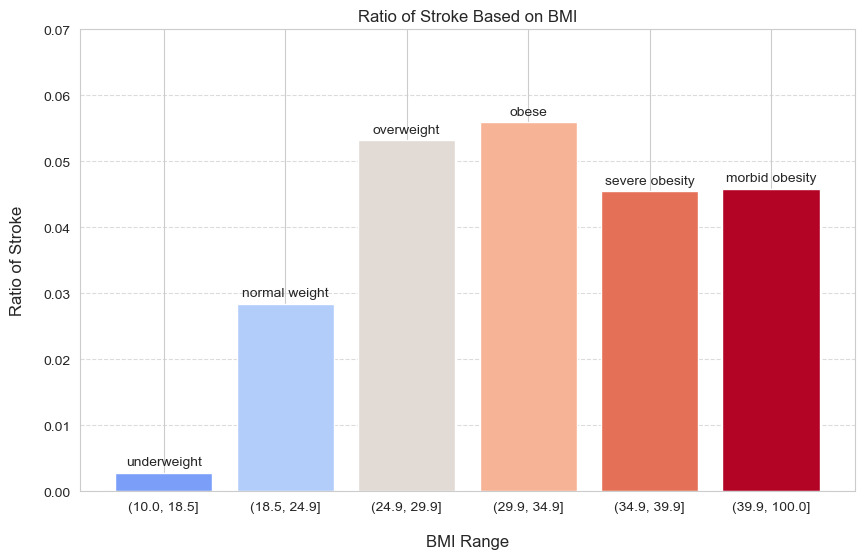

In [31]:
plt.figure(figsize=(10, 6))
cmap = plt.get_cmap('coolwarm')
colors = cmap(np.linspace(0.2, 1, len(stroke_ratios))) # Adjust the range (0.2 to 1) to control the darkness
bars = plt.bar(stroke_ratios.index.astype(str), stroke_ratios.values, color=colors)
plt.title('Ratio of Stroke Based on BMI')
plt.xlabel('BMI Range', labelpad = 15, fontsize = 12)
plt.ylabel('Ratio of Stroke', labelpad = 13, fontsize = 12)
plt.yticks(np.arange(0, 0.07, 0.01))
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Add labels to the bars
plt.bar_label(bars, labels=["underweight", "normal weight", "overweight", "obese", "severe obesity", 
                            "morbid obesity"], padding=3)
    
plt.show();

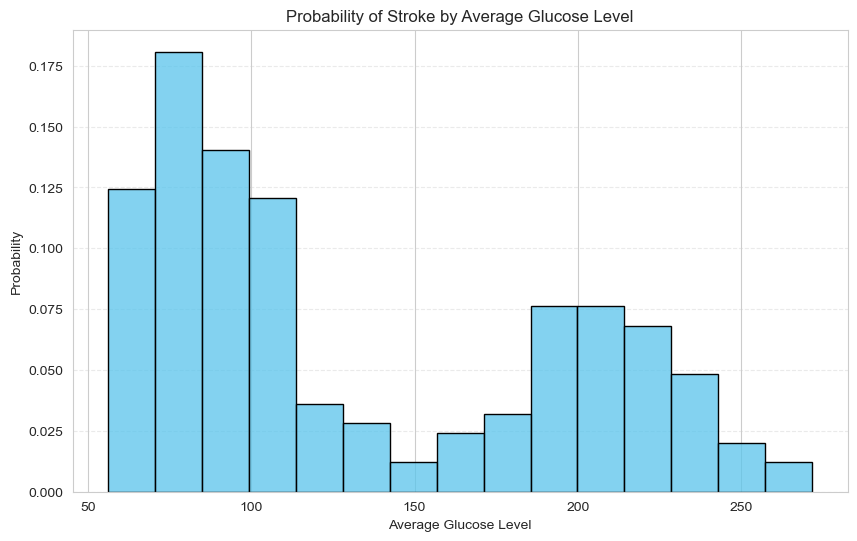

In [32]:
strokes_df = visual_df[visual_df['stroke'] == 1]
plt.figure(figsize=(10, 6))
sns.histplot(data=strokes_df, x='avg_glucose_level', color = "#59C4EC", edgecolor='black', stat = "probability", bins = 15)
plt.title('Probability of Stroke by Average Glucose Level')
plt.xlabel('Average Glucose Level')
plt.ylabel('Probability')
plt.grid(axis='y', linestyle='--', alpha=0.4)
plt.show();

C:\Users\bprit\AppData\Local\Temp\ipykernel_28160\1562695334.py:5: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_data = visual_complete_df.groupby(['ever_married', bmi_ranges])['stroke'].mean().reset_index()


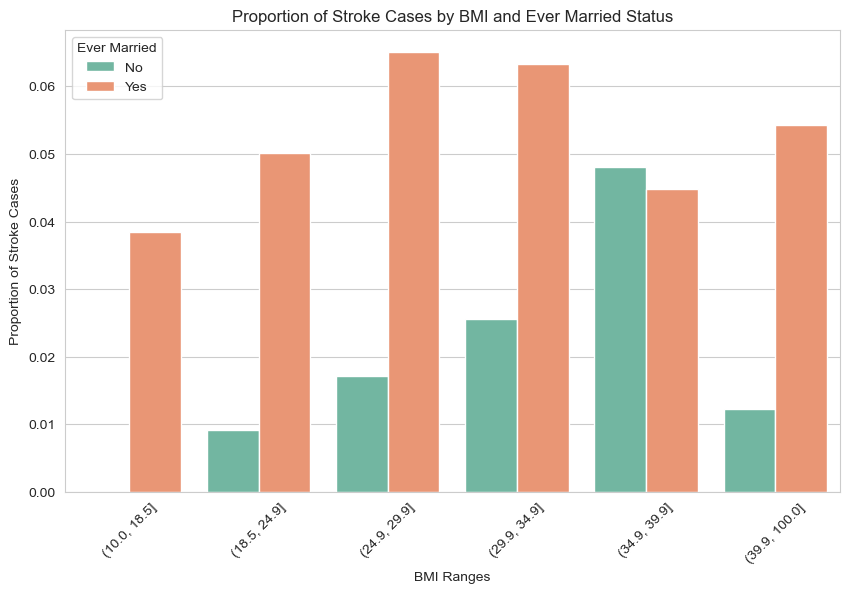

In [33]:
custom_bins = [10, 18.5, 24.9, 29.9, 34.9, 39.9, 100]
bmi_ranges = pd.cut(visual_complete_df['bmi'], bins=custom_bins)

# Group data by 'ever_married' and 'bmi_ranges' and calculate proportion of stroke cases
grouped_data = visual_complete_df.groupby(['ever_married', bmi_ranges])['stroke'].mean().reset_index()

# Plot grouped bar plot
plt.figure(figsize=(10, 6))
sns.barplot(data=grouped_data, x='bmi', y='stroke', hue='ever_married', palette='Set2')
plt.title('Proportion of Stroke Cases by BMI and Ever Married Status')
plt.xlabel('BMI Ranges')
plt.ylabel('Proportion of Stroke Cases')
plt.xticks(rotation=45)
plt.legend(title='Ever Married', loc='upper left')
plt.show()

C:\Users\bprit\AppData\Local\Temp\ipykernel_28160\636523960.py:5: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_data = visual_complete_df.groupby(['Hypertension', bmi_ranges])['stroke'].mean().reset_index()


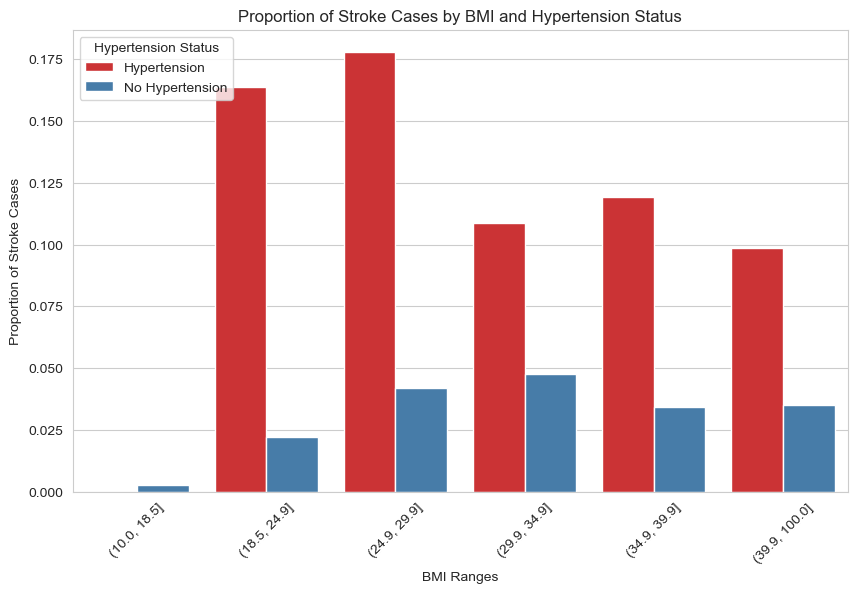

In [34]:
custom_bins = [10, 18.5, 24.9, 29.9, 34.9, 39.9, 100]
bmi_ranges = pd.cut(visual_complete_df['bmi'], bins=custom_bins)

# Group data by 'ever_married' and 'bmi_ranges' and calculate proportion of stroke cases
grouped_data = visual_complete_df.groupby(['Hypertension', bmi_ranges])['stroke'].mean().reset_index()

# Plot grouped bar plot
plt.figure(figsize=(10, 6))
sns.barplot(data=grouped_data, x='bmi', y='stroke', hue='Hypertension', palette='Set1')
plt.title('Proportion of Stroke Cases by BMI and Hypertension Status')
plt.xlabel('BMI Ranges')
plt.ylabel('Proportion of Stroke Cases')
plt.xticks(rotation=45)
plt.legend(title='Hypertension Status', loc='upper left')
plt.show()

## Let's now deal with the Missing Data in the BMI Column 

### First drop the id column

In [35]:
df = df.drop("id", axis = 1)

## Now perform Label Encoding, but store the information for how the encoding happens

We will convert each column that contains strings into numerical values. We will do this using LabelEncoder because we have much too many columns that need to be converted into numerical data. 
After performing LabelEncoder, to increase accuracy and not let the model think the columns are ordered in some kind of numerical fashion, we will implement one hot encoding on the columns: "work_type" and "smoking_status"

In [36]:
def label_encode_df(df):
    label_mapping = {}
    encoded_df = df.copy()

    for col in df.columns:
        if df[col].dtype == 'object':
            label_encoder = LabelEncoder()
            encoded_df[col] = label_encoder.fit_transform(df[col])
            label_mapping[col] = dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_)))

    return encoded_df, label_mapping

# Example usage:
# Assuming df is your DataFrame
encoded_df, label_mapping = label_encode_df(df)

# Now encoded_df contains label-encoded values, and label_mapping contains the mapping of original string values to numerical labels for each column


In [37]:
encoded_df.head(20)

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,1,67.0,0,1,1,2,1,228.69,36.6,1,1
1,0,61.0,0,0,1,3,0,202.21,NaN,2,1
2,1,80.0,0,1,1,2,0,105.92,32.5,2,1
3,0,49.0,0,0,1,2,1,171.23,34.4,3,1
4,0,79.0,1,0,1,3,0,174.12,24.0,2,1
5,1,81.0,0,0,1,2,1,186.21,29.0,1,1
6,1,74.0,1,1,1,2,0,70.09,27.4,2,1
7,0,69.0,0,0,0,2,1,94.39,22.8,2,1
8,0,59.0,0,0,1,2,0,76.15,NaN,0,1
9,0,78.0,0,0,1,2,1,58.57,24.2,0,1


## Apply One Hot Encoding on the columns:"work_type" and "smoking_status", since these columns each contain more than two unique values

In [38]:
encoded_df = pd.get_dummies(encoded_df, columns = ["work_type", "smoking_status"], dtype=int) 
encoded_df

,gender,age,hypertension,heart_disease,ever_married,Residence_type,avg_glucose_level,bmi,stroke,work_type_0,work_type_1,work_type_2,work_type_3,work_type_4,smoking_status_0,smoking_status_1,smoking_status_2,smoking_status_3
0,1,67.0,0,1,1,1,228.69,36.6,1,0,0,1,0,0,0,1,0,0
1,0,61.0,0,0,1,0,202.21,NaN,1,0,0,0,1,0,0,0,1,0
2,1,80.0,0,1,1,0,105.92,32.5,1,0,0,1,0,0,0,0,1,0
3,0,49.0,0,0,1,1,171.23,34.4,1,0,0,1,0,0,0,0,0,1
4,0,79.0,1,0,1,0,174.12,24.0,1,0,0,0,1,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5105,0,80.0,1,0,1,1,83.75,NaN,0,0,0,1,0,0,0,0,1,0
5106,0,81.0,0,0,1,1,125.20,40.0,0,0,0,0,1,0,0,0,1,0
5107,0,35.0,0,0,1,0,82.99,30.6,0,0,0,0,1,0,0,0,1,0
5108,1,51.0,0,0,1,0,166.29,25.6,0,0,0,1,0,0,0,1,0,0


In [39]:
encoded_df.columns

Index(['gender', 'age', 'hypertension', 'heart_disease', 'ever_married',
       'Residence_type', 'avg_glucose_level', 'bmi', 'stroke', 'work_type_0',
       'work_type_1', 'work_type_2', 'work_type_3', 'work_type_4',
       'smoking_status_0', 'smoking_status_1', 'smoking_status_2',
       'smoking_status_3'],
      dtype='object')

### We can now use the encoded_df to implement Linear Regression

## Let's use Linear Regression to fill in the Missing Data in the BMI Column. Do linear regression BEFORE going into your machine learning prediction codes

In [40]:
# Splitting the dataset into parts with missing and complete "bmi" values
missing_data = encoded_df[encoded_df['bmi'].isnull()]
complete_data = encoded_df.dropna(subset=['bmi'])

In [41]:
missing_data

,gender,age,hypertension,heart_disease,ever_married,Residence_type,avg_glucose_level,bmi,stroke,work_type_0,work_type_1,work_type_2,work_type_3,work_type_4,smoking_status_0,smoking_status_1,smoking_status_2,smoking_status_3
1,0,61.0,0,0,1,0,202.21,NaN,1,0,0,0,1,0,0,0,1,0
8,0,59.0,0,0,1,0,76.15,NaN,1,0,0,1,0,0,1,0,0,0
13,1,78.0,0,1,1,1,219.84,NaN,1,0,0,1,0,0,1,0,0,0
19,1,57.0,0,1,0,1,217.08,NaN,1,1,0,0,0,0,1,0,0,0
27,1,58.0,0,0,1,0,189.84,NaN,1,0,0,1,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5039,1,41.0,0,0,0,0,70.15,NaN,0,0,0,1,0,0,0,1,0,0
5048,1,40.0,0,0,1,1,191.15,NaN,0,0,0,1,0,0,0,0,0,1
5093,0,45.0,1,0,1,0,95.02,NaN,0,1,0,0,0,0,0,0,0,1
5099,1,40.0,0,0,1,0,83.94,NaN,0,0,0,1,0,0,0,0,0,1


In [42]:
complete_data

,gender,age,hypertension,heart_disease,ever_married,Residence_type,avg_glucose_level,bmi,stroke,work_type_0,work_type_1,work_type_2,work_type_3,work_type_4,smoking_status_0,smoking_status_1,smoking_status_2,smoking_status_3
0,1,67.0,0,1,1,1,228.69,36.6,1,0,0,1,0,0,0,1,0,0
2,1,80.0,0,1,1,0,105.92,32.5,1,0,0,1,0,0,0,0,1,0
3,0,49.0,0,0,1,1,171.23,34.4,1,0,0,1,0,0,0,0,0,1
4,0,79.0,1,0,1,0,174.12,24.0,1,0,0,0,1,0,0,0,1,0
5,1,81.0,0,0,1,1,186.21,29.0,1,0,0,1,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5104,0,13.0,0,0,0,0,103.08,18.6,0,0,0,0,0,1,1,0,0,0
5106,0,81.0,0,0,1,1,125.20,40.0,0,0,0,0,1,0,0,0,1,0
5107,0,35.0,0,0,1,0,82.99,30.6,0,0,0,0,1,0,0,0,1,0
5108,1,51.0,0,0,1,0,166.29,25.6,0,0,0,1,0,0,0,1,0,0


In [43]:
# Extracting features (excluding "stroke" column) for training
X_train = complete_data.drop(columns=['bmi', 'stroke'])
y_train = complete_data['bmi']

# Training a decision tree model
model = LinearRegression()  
model.fit(X_train, y_train)

LinearRegression()

In [44]:
# Extracting features for imputation
X_missing = missing_data.drop(columns=['bmi', 'stroke'])

# Imputing missing "bmi" values
predicted_bmi = model.predict(X_missing)

# Adding predicted "bmi" values back to the original DataFrame
encoded_df.loc[encoded_df['bmi'].isnull(), 'bmi'] = predicted_bmi

In [45]:
encoded_df

,gender,age,hypertension,heart_disease,ever_married,Residence_type,avg_glucose_level,bmi,stroke,work_type_0,work_type_1,work_type_2,work_type_3,work_type_4,smoking_status_0,smoking_status_1,smoking_status_2,smoking_status_3
0,1,67.0,0,1,1,1,228.69,36.600000,1,0,0,1,0,0,0,1,0,0
1,0,61.0,0,0,1,0,202.21,31.850561,1,0,0,0,1,0,0,0,1,0
2,1,80.0,0,1,1,0,105.92,32.500000,1,0,0,1,0,0,0,0,1,0
3,0,49.0,0,0,1,1,171.23,34.400000,1,0,0,1,0,0,0,0,0,1
4,0,79.0,1,0,1,0,174.12,24.000000,1,0,0,0,1,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5105,0,80.0,1,0,1,1,83.75,32.129547,0,0,0,1,0,0,0,0,1,0
5106,0,81.0,0,0,1,1,125.20,40.000000,0,0,0,0,1,0,0,0,1,0
5107,0,35.0,0,0,1,0,82.99,30.600000,0,0,0,0,1,0,0,0,1,0
5108,1,51.0,0,0,1,0,166.29,25.600000,0,0,0,1,0,0,0,1,0,0


##### Now filled_data contains the original data but with the missing "bmi" values imputed with the linear regression model

In [46]:
encoded_df.isna().sum()

gender               0
age                  0
hypertension         0
heart_disease        0
ever_married         0
Residence_type       0
avg_glucose_level    0
bmi                  0
stroke               0
work_type_0          0
work_type_1          0
work_type_2          0
work_type_3          0
work_type_4          0
smoking_status_0     0
smoking_status_1     0
smoking_status_2     0
smoking_status_3     0
dtype: int64

In [47]:
encoded_df.loc[[1, 8]]

,gender,age,hypertension,heart_disease,ever_married,Residence_type,avg_glucose_level,bmi,stroke,work_type_0,work_type_1,work_type_2,work_type_3,work_type_4,smoking_status_0,smoking_status_1,smoking_status_2,smoking_status_3
1,0,61.0,0,0,1,0,202.21,31.850561,1,0,0,0,1,0,0,0,1,0
8,0,59.0,0,0,1,0,76.15,29.473494,1,0,0,1,0,0,1,0,0,0


### Let's quickly build a correlation matrix 

In [48]:
corr_matrix = encoded_df.corr()
corr_matrix

,gender,age,hypertension,heart_disease,ever_married,Residence_type,avg_glucose_level,bmi,stroke,work_type_0,work_type_1,work_type_2,work_type_3,work_type_4,smoking_status_0,smoking_status_1,smoking_status_2,smoking_status_3
gender,1.000000,-0.028202,0.020994,0.085447,-0.031005,-0.006738,0.055180,-0.024885,0.008929,-0.016823,0.011433,-0.031922,-0.026293,0.088886,0.059079,0.044432,-0.099328,0.011127
age,-0.028202,1.000000,0.276398,0.263796,0.679125,0.014180,0.238171,0.336930,0.245257,0.130013,-0.078653,0.116534,0.327989,-0.634215,-0.378231,0.236897,0.119307,0.073133
hypertension,0.020994,0.276398,1.000000,0.108306,0.164243,-0.007913,0.174474,0.173420,0.127904,0.017685,-0.021608,-0.005413,0.115442,-0.129506,-0.141501,0.058853,0.065063,0.031240
heart_disease,0.085447,0.263796,0.108306,1.000000,0.114644,0.003092,0.161857,0.042489,0.134914,0.001330,-0.015712,0.000027,0.086760,-0.091634,-0.066731,0.066804,-0.021856,0.044049
ever_married,-0.031005,0.679125,0.164243,0.114644,1.000000,0.006261,0.155068,0.345795,0.108340,0.134041,-0.090838,0.153830,0.192716,-0.544441,-0.332081,0.171256,0.102845,0.105226
Residence_type,-0.006738,0.014180,-0.007913,0.003092,0.006261,1.000000,-0.004946,-0.000854,0.015458,0.013131,0.022859,-0.018173,0.010594,-0.002309,-0.002036,0.007654,-0.024466,0.027266
avg_glucose_level,0.055180,0.238171,0.174474,0.161857,0.155068,-0.004946,1.000000,0.180406,0.131945,0.013845,-0.014675,0.016588,0.062694,-0.102250,-0.095131,0.068111,0.023885,0.017646
bmi,-0.024885,0.336930,0.173420,0.042489,0.345795,-0.000854,0.180406,1.000000,0.043329,0.079112,-0.028896,0.208913,0.072947,-0.453514,-0.271012,0.107040,0.105690,0.091069
stroke,0.008929,0.245257,0.127904,0.134914,0.108340,0.015458,0.131945,0.043329,1.000000,0.002677,-0.014882,0.011888,0.062168,-0.083869,-0.055892,0.064556,-0.004129,0.008939
work_type_0,-0.016823,0.130013,0.017685,0.001330,0.134041,0.013131,0.013845,0.079112,0.002677,1.000000,-0.025258,-0.444420,-0.167810,-0.151383,-0.097418,0.029686,0.046908,0.030026


In [49]:
mask = np.zeros_like(corr_matrix)
upper_triangle_indices = np.triu_indices_from(mask)
mask[upper_triangle_indices] = True

<Axes: >

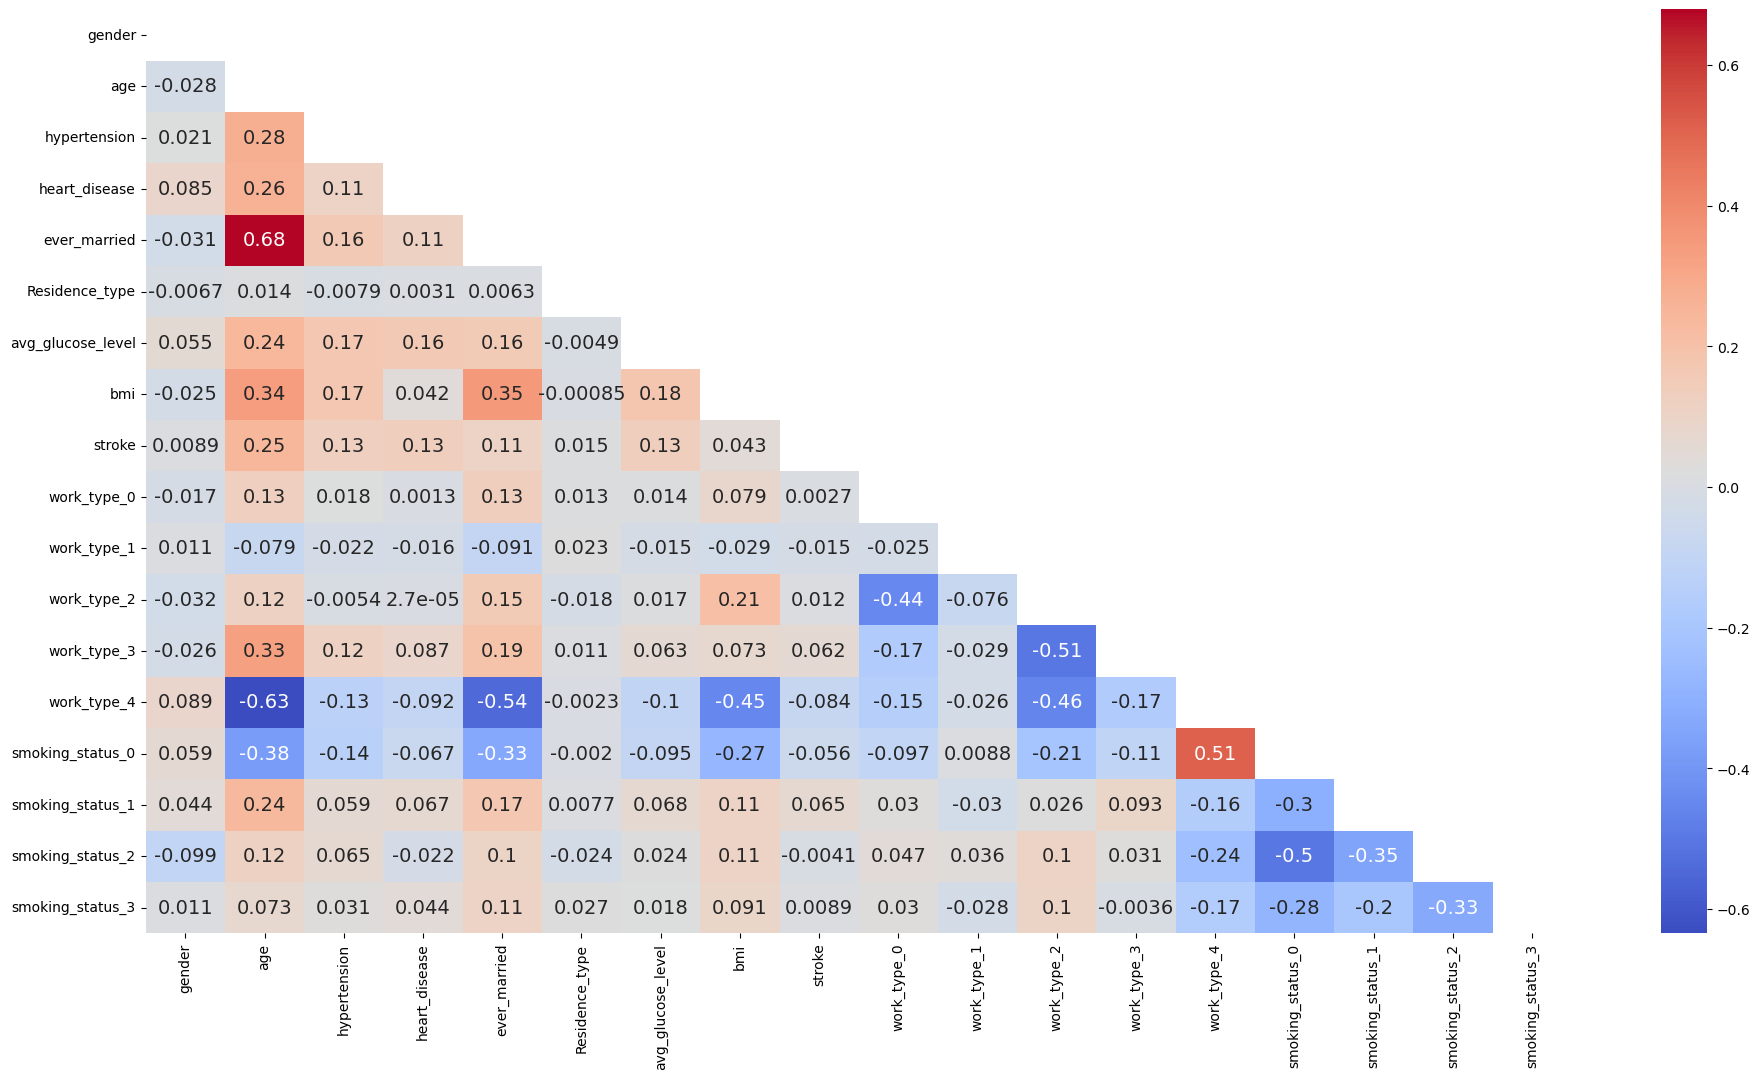

In [50]:
plt.figure(figsize=(23, 12))
plt.style.use("default")
sns.heatmap(corr_matrix, annot = True, mask = mask, cmap = "coolwarm", annot_kws = {"size": 14})

## Logistic Regression Model

### Scale the numerical features in the df using Normal Distribution Scaling (aka Standard Scaler)

In [51]:
X = encoded_df.drop("stroke", axis = "columns")
y = encoded_df["stroke"]

In [52]:
y

0       1
1       1
2       1
3       1
4       1
       ..
5105    0
5106    0
5107    0
5108    0
5109    0
Name: stroke, Length: 5110, dtype: int64

In [53]:
# Scale only the features: "age", "bmi", and "avg_glucose_level"
data = X[["age", "bmi","avg_glucose_level"]]
 
# compute required values
scaler = StandardScaler()
features_scaled = scaler.fit_transform(data)

# print scaled data
print(features_scaled[:3])

[[ 1.05143428  0.99051116  2.70637544]
 [ 0.78607007  0.37615044  2.12155854]
 [ 1.62639008  0.46015818 -0.0050283 ]]


In [54]:
X[["age", "bmi","avg_glucose_level"]] = features_scaled
X

,gender,age,hypertension,heart_disease,ever_married,Residence_type,avg_glucose_level,bmi,work_type_0,work_type_1,work_type_2,work_type_3,work_type_4,smoking_status_0,smoking_status_1,smoking_status_2,smoking_status_3
0,1,1.051434,0,1,1,1,2.706375,0.990511,0,0,1,0,0,0,1,0,0
1,0,0.786070,0,0,1,0,2.121559,0.376150,0,0,0,1,0,0,0,1,0
2,1,1.626390,0,1,1,0,-0.005028,0.460158,0,0,1,0,0,0,0,1,0
3,0,0.255342,0,0,1,1,1.437358,0.705932,0,0,1,0,0,0,0,0,1
4,0,1.582163,1,0,1,0,1.501184,-0.639354,0,0,0,1,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5105,0,1.626390,1,0,1,1,-0.494658,0.412239,0,0,1,0,0,0,0,1,0
5106,0,1.670617,0,0,1,1,0.420775,1.430316,0,0,0,1,0,0,0,1,0
5107,0,-0.363842,0,0,1,0,-0.511443,0.214385,0,0,0,1,0,0,0,1,0
5108,1,0.343796,0,0,1,0,1.328257,-0.432387,0,0,1,0,0,0,1,0,0


### Let's now apply a Logistic Regression model without feature selection and random oversampling and see how it performs 

Accuracy: 0.9381846635367762
              precision    recall  f1-score   support

           0       0.94      1.00      0.97      1198
           1       1.00      0.01      0.02        80

    accuracy                           0.94      1278
   macro avg       0.97      0.51      0.50      1278
weighted avg       0.94      0.94      0.91      1278


Specificity Score: 0.0125


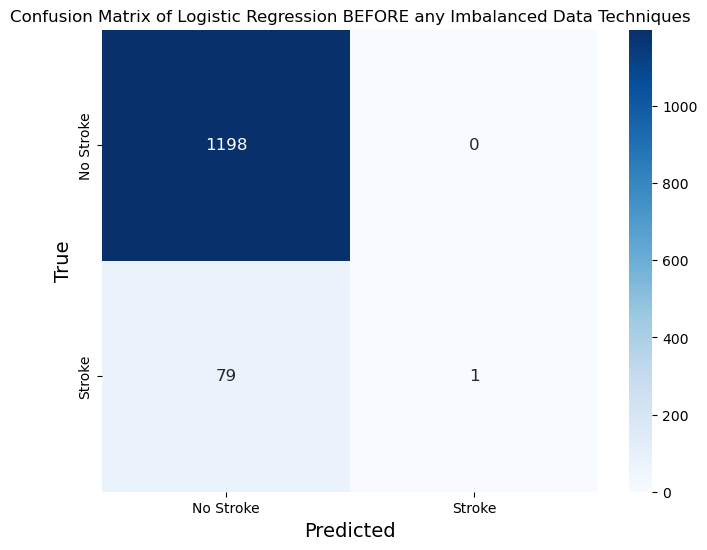

In [55]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state = 42)

model = LogisticRegression(max_iter=5000, C = 0.5)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)
print(classification_report(y_test, y_pred))

tp, fn, fp, tn = confusion_matrix(y_test, y_pred).ravel()

# Get specificity score:
specificity = tn / (tn + fp)

print("\nSpecificity Score:", specificity)

cm = confusion_matrix(y_test, y_pred)

# Visualize confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, cmap="Blues", fmt="g", annot_kws={"fontsize": 12}, 
           xticklabels=['No Stroke', 'Stroke'], yticklabels=['No Stroke', 'Stroke'])
plt.title("Confusion Matrix of Logistic Regression BEFORE any Imbalanced Data Techniques")
plt.xlabel("Predicted", fontsize=14)
plt.ylabel("True", fontsize=14)
plt.show()

### Let's now build our Logistic Regression model with feature selection and random oversampling

In [56]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state = 42)

#Define the base classifier:
base_estimator = DecisionTreeClassifier(random_state=42)

# Define the sequential backward search
feature_selector = SequentialFeatureSelector(base_estimator, n_features_to_select = "auto", 
                                             direction='backward', cv=5, tol = 0.03, scoring = "roc_auc")

feature_selector.fit(X_train, y_train)

# Access the indices of the selected features
selected_feature_indices = feature_selector.get_support(indices=True)

print("Selected Feature Indices:", selected_feature_indices)

Selected Feature Indices: [ 0  1  2  3  4  5  6  7  9 10 11 12 13 14 15 16]


In [57]:
X_train_selected = feature_selector.transform(X_train)
X_test_selected = feature_selector.transform(X_test)

In [58]:
## Making sure the feature_selector chose the right columns
selected_feature_names = X_train.columns[selected_feature_indices]
print("Selected Feature Names:", selected_feature_names)

Selected Feature Names: Index(['gender', 'age', 'hypertension', 'heart_disease', 'ever_married',
       'Residence_type', 'avg_glucose_level', 'bmi', 'work_type_1',
       'work_type_2', 'work_type_3', 'work_type_4', 'smoking_status_0',
       'smoking_status_1', 'smoking_status_2', 'smoking_status_3'],
      dtype='object')


In [59]:
# Perform random undersampling to balance the classes
oversampler = RandomOverSampler(random_state=42)
X_train_resampled, y_train_resampled = oversampler.fit_resample(X_train_selected, y_train)

# Apply higher weight for stroke patients because these predictions are more important
weights = {0: 1, 1: 1.4}  

# Define logistic regression classifier with our custom class weights
log_reg = LogisticRegression(class_weight = weights, max_iter=5000, C = 0.5)
log_reg.fit(X_train_resampled, y_train_resampled)

# Predict on the training set
y_train_pred = log_reg.predict(X_train_resampled)

# Calculate training accuracy
train_accuracy = accuracy_score(y_train_resampled, y_train_pred)
print("Training Accuracy:", train_accuracy)

#Predict on testing set
y_pred = log_reg.predict(X_test_selected)

#Scores for testing set
accuracy = accuracy_score(y_test, y_pred)
print("\nTest Accuracy:", accuracy)
print(classification_report(y_test, y_pred))


Training Accuracy: 0.786923286923287

Test Accuracy: 0.7065727699530516
              precision    recall  f1-score   support

           0       0.99      0.70      0.82      1198
           1       0.16      0.86      0.27        80

    accuracy                           0.71      1278
   macro avg       0.57      0.78      0.54      1278
weighted avg       0.94      0.71      0.78      1278



In [60]:
tp, fn, fp, tn = confusion_matrix(y_test, y_pred).ravel()

# Get specificity score:
specificity = tn / (tn + fp)

print("Specificity Score:", specificity)

Specificity Score: 0.8625


In [61]:
cm = confusion_matrix(y_test, y_pred)
cm

array([[834, 364],
       [ 11,  69]], dtype=int64)

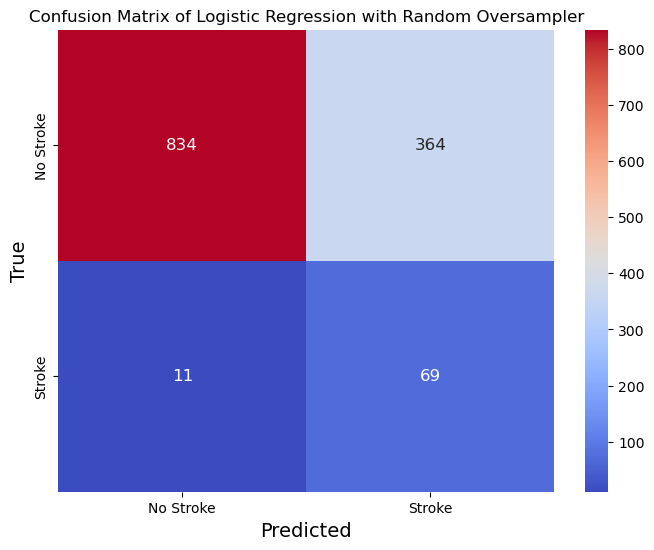

In [62]:
# Visualize confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, cmap="coolwarm", fmt="g", annot_kws={"fontsize": 12}, 
           xticklabels=['No Stroke', 'Stroke'], yticklabels=['No Stroke', 'Stroke'])
plt.title("Confusion Matrix of Logistic Regression with Random Oversampler")
plt.xlabel("Predicted", fontsize=14)
plt.ylabel("True", fontsize=14)
plt.show()

In [63]:
cm_norm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
cm_norm

array([[0.69616027, 0.30383973],
       [0.1375    , 0.8625    ]])

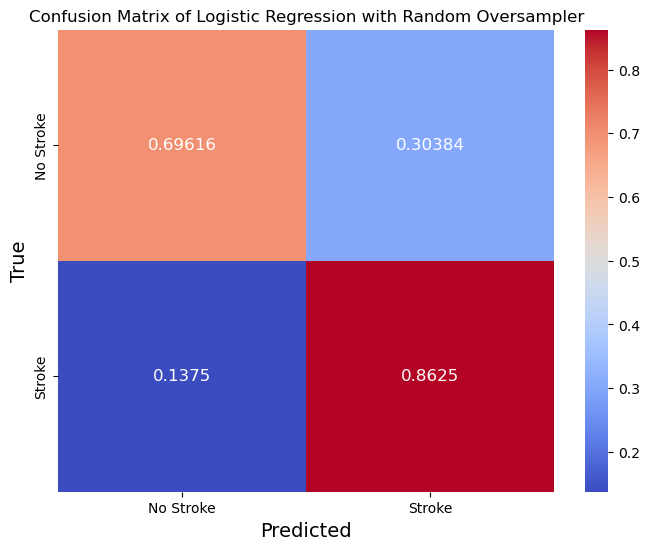

In [64]:
# Visualize confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm_norm, annot=True, cmap="coolwarm", fmt="g", annot_kws={"fontsize": 12}, 
           xticklabels=['No Stroke', 'Stroke'], yticklabels=['No Stroke', 'Stroke'])
plt.title("Confusion Matrix of Logistic Regression with Random Oversampler")
plt.xlabel("Predicted", fontsize=14)
plt.ylabel("True", fontsize=14)
plt.show()

In [65]:
print(f"Weights of Logistic Regression Model: \n\n{log_reg.coef_}")

Weights of Logistic Regression Model: 

[[-0.1864988   1.8947157   0.73949213  0.3088767  -0.21394042 -0.0055753
   0.17112591 -0.00928908 -0.2465083   0.13996433 -0.10024512  1.78436046
  -0.04749167 -0.04822317 -0.27634662  0.36818698]]


## Check Robustness of Random Oversampler Logistic Regression Model:

### Check 1: 
### Let's now apply a Logistic Regression model with the same feature selection but without random oversampling and see how it performs 

In [66]:
print("Selected Feature Indices:", selected_feature_indices)

Selected Feature Indices: [ 0  1  2  3  4  5  6  7  9 10 11 12 13 14 15 16]


In [67]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state = 42)

X_train_selected = feature_selector.transform(X_train)
X_test_selected = feature_selector.transform(X_test)

Accuracy: 0.701095461658842
              precision    recall  f1-score   support

           0       0.99      0.69      0.81      1198
           1       0.16      0.86      0.27        80

    accuracy                           0.70      1278
   macro avg       0.57      0.78      0.54      1278
weighted avg       0.93      0.70      0.78      1278


Specificity Score: 0.8625


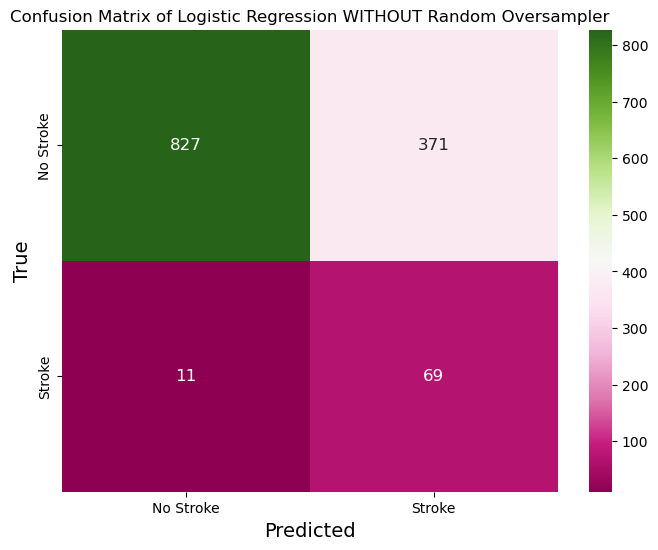

In [68]:
# Apply higher weight for stroke patients because these predictions are more important
weights = {0: 1, 1: 32} 

model = LogisticRegression(class_weight = weights, max_iter=5000, C = 0.5)
model.fit(X_train_selected, y_train)

y_pred = model.predict(X_test_selected)

accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)
print(classification_report(y_test, y_pred))

tp, fn, fp, tn = confusion_matrix(y_test, y_pred).ravel()

# Get specificity score:
specificity = tn / (tn + fp)

print("\nSpecificity Score:", specificity)

cm = confusion_matrix(y_test, y_pred)

# Visualize confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, cmap="PiYG", fmt="g", annot_kws={"fontsize": 12}, 
           xticklabels=['No Stroke', 'Stroke'], yticklabels=['No Stroke', 'Stroke'])
plt.title("Confusion Matrix of Logistic Regression WITHOUT Random Oversampler")
plt.xlabel("Predicted", fontsize=14)
plt.ylabel("True", fontsize=14)
plt.show()

## Neural Network

In [69]:
import torch
import torch.nn as nn
from imblearn.over_sampling import SMOTE

X = encoded_df.drop(columns=['stroke'], axis = "columns")
y = encoded_df['stroke']

#Scale the numerical features in X using Standard Scaler
data = X[["age", "bmi","avg_glucose_level"]]

scaler = StandardScaler()
features_scaled = scaler.fit_transform(data)

X[["age", "bmi","avg_glucose_level"]] = features_scaled
#X

In [70]:
X_scaled = X.values
y_scaled = y.values

In [71]:
# Split the data into training and testing sets BEFORE transforming the data with SMOTE.
#You will only be transforming the X_train and y_train data, NOT the entire data (because otherwise this
#creates data leakage for your model)

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_scaled, test_size=0.2, random_state=42)

In [72]:
# Apply SMOTE to oversample the minority class
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

In [73]:
# Convert data to PyTorch tensors
X_train_tensor = torch.tensor(X_train_resampled, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train_resampled.reshape(-1, 1), dtype=torch.float32)
y_test_tensor = torch.tensor(y_test.reshape(-1, 1), dtype=torch.float32)

# Define the neural network architecture
class NeuralNetwork(nn.Module):
    def __init__(self):
        super(NeuralNetwork, self).__init__()
        self.fc1 = nn.Linear(X_train_resampled.shape[1], 10)  # First hidden layer with 10 neurons
        self.relu = nn.ReLU()  # ReLU activation function
        self.fc2 = nn.Linear(10, 5)  # Second hidden layer with 5 neurons
        self.sigmoid = nn.Sigmoid()  # Sigmoid activation function
        self.output = nn.Linear(5, 1)  # Output layer with single neuron for binary classification

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        x = self.sigmoid(x)
        x = self.output(x)
        return x

# Initialize the neural network
model = NeuralNetwork()

# Define loss function and optimizer
criterion = nn.BCEWithLogitsLoss()  # Binary cross-entropy loss
optimizer = optim.SGD(model.parameters(), lr=0.11)  # Stochastic Gradient Descent optimizer

# Training the neural network
epochs = 1000
for epoch in range(epochs):
    # Forward pass
    outputs = model(X_train_tensor)
    loss = criterion(outputs, y_train_tensor)

    # Backward pass and optimization
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    # Print loss every 10 epochs
    if (epoch + 1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{epochs}], Loss: {loss.item()}')

# Evaluate the trained model
with torch.no_grad():
    model.eval()
    outputs = model(X_test_tensor)
    predictions = torch.round(torch.sigmoid(outputs))
    correct = (predictions == y_test_tensor).sum().item()
    total = y_test_tensor.size(0)
    accuracy = correct / total
    print(f'Accuracy: {accuracy}')

Epoch [10/1000], Loss: 0.6941279172897339
Epoch [20/1000], Loss: 0.692818284034729
Epoch [30/1000], Loss: 0.6921466588973999
Epoch [40/1000], Loss: 0.691620409488678
Epoch [50/1000], Loss: 0.6911125779151917
Epoch [60/1000], Loss: 0.6905864477157593
Epoch [70/1000], Loss: 0.6900282502174377
Epoch [80/1000], Loss: 0.6894275546073914
Epoch [90/1000], Loss: 0.6887738108634949
Epoch [100/1000], Loss: 0.6880571246147156
Epoch [110/1000], Loss: 0.6872658133506775
Epoch [120/1000], Loss: 0.68638676404953
Epoch [130/1000], Loss: 0.6854044198989868
Epoch [140/1000], Loss: 0.6843000650405884
Epoch [150/1000], Loss: 0.6830511093139648
Epoch [160/1000], Loss: 0.6816323399543762
Epoch [170/1000], Loss: 0.680013120174408
Epoch [180/1000], Loss: 0.6781534552574158
Epoch [190/1000], Loss: 0.6760110855102539
Epoch [200/1000], Loss: 0.6735339760780334
Epoch [210/1000], Loss: 0.670663058757782
Epoch [220/1000], Loss: 0.667325496673584
Epoch [230/1000], Loss: 0.6634430885314941
Epoch [240/1000], Loss: 0.6

In [74]:
predictions_np = predictions.numpy().astype(int)
y_test_np = y_test_tensor.numpy().astype(int)

cm = confusion_matrix(y_test_np, predictions_np)
print("Confusion Matrix:")
print(cm)

Confusion Matrix:
[[684 276]
 [  8  54]]


In [75]:
# Classification report
report = classification_report(y_test_np, predictions_np)
print("\nClassification Report:")
print(report)


Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.71      0.83       960
           1       0.16      0.87      0.28        62

    accuracy                           0.72      1022
   macro avg       0.58      0.79      0.55      1022
weighted avg       0.94      0.72      0.79      1022



In [76]:
tp, fn, fp, tn = confusion_matrix(y_test_np, predictions_np).ravel()

# Get specificity score:
specificity = tn / (tn + fp)

print("Specificity Score:", specificity)

Specificity Score: 0.8709677419354839


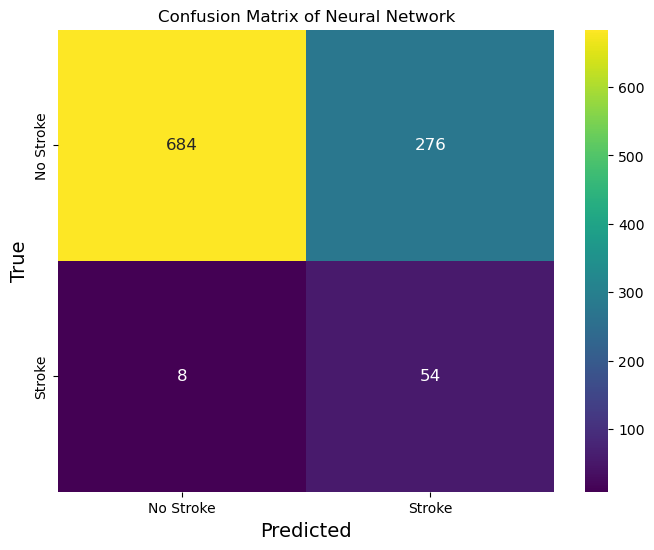

In [77]:
# Confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, cmap="viridis", fmt="g", annot_kws={"fontsize": 12}, 
           xticklabels=['No Stroke', 'Stroke'], yticklabels=['No Stroke', 'Stroke'])
plt.title("Confusion Matrix of Neural Network")
plt.xlabel("Predicted", fontsize=14)
plt.ylabel("True", fontsize=14)
plt.show()

## Check Robustness of the Random Oversampler Logistic Regression Model

### Check 2:
### We will now implement the same Logistic Regression Model with Random Oversampler as before, but this time on the dataset that completely removes the "bmi" missing instances from the dataframe. We will see how much filling in these features impacted the model.

### Earlier in the project, we had already created the dataframe that does not contain these missing "bmi" values. It is called: "complete_data"

In [78]:
complete_data

,gender,age,hypertension,heart_disease,ever_married,Residence_type,avg_glucose_level,bmi,stroke,work_type_0,work_type_1,work_type_2,work_type_3,work_type_4,smoking_status_0,smoking_status_1,smoking_status_2,smoking_status_3
0,1,67.0,0,1,1,1,228.69,36.6,1,0,0,1,0,0,0,1,0,0
2,1,80.0,0,1,1,0,105.92,32.5,1,0,0,1,0,0,0,0,1,0
3,0,49.0,0,0,1,1,171.23,34.4,1,0,0,1,0,0,0,0,0,1
4,0,79.0,1,0,1,0,174.12,24.0,1,0,0,0,1,0,0,0,1,0
5,1,81.0,0,0,1,1,186.21,29.0,1,0,0,1,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5104,0,13.0,0,0,0,0,103.08,18.6,0,0,0,0,0,1,1,0,0,0
5106,0,81.0,0,0,1,1,125.20,40.0,0,0,0,0,1,0,0,0,1,0
5107,0,35.0,0,0,1,0,82.99,30.6,0,0,0,0,1,0,0,0,1,0
5108,1,51.0,0,0,1,0,166.29,25.6,0,0,0,1,0,0,0,1,0,0


In [79]:
X = complete_data.drop("stroke", axis = "columns")
y = complete_data["stroke"]

# Scale only the features: "age", "bmi", and "avg_glucose_level"
data = X[["age", "bmi","avg_glucose_level"]]
 
# compute required values
scaler = StandardScaler()
features_scaled = scaler.fit_transform(data)

# print scaled data
print(features_scaled[:3])

X[["age", "bmi","avg_glucose_level"]] = features_scaled
X

[[1.07013796 0.98134488 2.77769839]
 [1.64656262 0.45926914 0.0138418 ]
 [0.27201152 0.70120668 1.48413156]]


,gender,age,hypertension,heart_disease,ever_married,Residence_type,avg_glucose_level,bmi,work_type_0,work_type_1,work_type_2,work_type_3,work_type_4,smoking_status_0,smoking_status_1,smoking_status_2,smoking_status_3
0,1,1.070138,0,1,1,1,2.777698,0.981345,0,0,1,0,0,0,1,0,0
2,1,1.646563,0,1,1,0,0.013842,0.459269,0,0,1,0,0,0,0,1,0
3,0,0.272012,0,0,1,1,1.484132,0.701207,0,0,1,0,0,0,0,0,1
4,0,1.602222,1,0,1,0,1.549193,-0.623083,0,0,0,1,0,0,0,1,0
5,1,1.690903,0,0,1,1,1.821368,0.013595,0,0,1,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5104,0,-1.324241,0,0,0,0,-0.050094,-1.310695,0,0,0,0,1,1,0,0,0
5106,0,1.690903,0,0,1,1,0.447882,1.414286,0,0,0,1,0,0,0,1,0
5107,0,-0.348753,0,0,1,0,-0.502369,0.217332,0,0,0,1,0,0,0,1,0
5108,1,0.360692,0,0,1,0,1.372920,-0.419346,0,0,1,0,0,0,1,0,0


In [80]:
print("Selected Feature Indices:", selected_feature_indices)

Selected Feature Indices: [ 0  1  2  3  4  5  6  7  9 10 11 12 13 14 15 16]


In [81]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state = 53)

X_train_selected = feature_selector.transform(X_train)
X_test_selected = feature_selector.transform(X_test)

## Making sure the feature_selector chose the right columns
selected_feature_names = X_train.columns[selected_feature_indices]
print("Selected Feature Names:", selected_feature_names)

Selected Feature Names: Index(['gender', 'age', 'hypertension', 'heart_disease', 'ever_married',
       'Residence_type', 'avg_glucose_level', 'bmi', 'work_type_1',
       'work_type_2', 'work_type_3', 'work_type_4', 'smoking_status_0',
       'smoking_status_1', 'smoking_status_2', 'smoking_status_3'],
      dtype='object')


In [82]:
X_train_selected

array([[ 0.        , -0.52611492,  0.        , ...,  0.        ,
         0.        ,  1.        ],
       [ 0.        , -0.1270517 ,  0.        , ...,  0.        ,
         1.        ,  0.        ],
       [ 1.        , -0.03837098,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [ 0.        , -0.83649743,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.09465009,  0.        , ...,  0.        ,
         1.        ,  0.        ],
       [ 0.        ,  0.44937295,  0.        , ...,  0.        ,
         0.        ,  0.        ]])

In [83]:
# Perform random oversampling to balance the classes
oversampler = RandomOverSampler(random_state=42)
X_train_resampled, y_train_resampled = oversampler.fit_resample(X_train_selected, y_train)

# Apply higher weight for stroke patients because these predictions are more important
weights = {0: 1, 1: 1.3}  

# Define logistic regression classifier with our custom class weights
log_reg = LogisticRegression(class_weight = weights, max_iter=5000, C = 0.5)
log_reg.fit(X_train_resampled, y_train_resampled)

y_pred = log_reg.predict(X_test_selected)

accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)
print(classification_report(y_test, y_pred))

Accuracy: 0.6824104234527687
              precision    recall  f1-score   support

           0       0.99      0.67      0.80      1168
           1       0.12      0.87      0.21        60

    accuracy                           0.68      1228
   macro avg       0.55      0.77      0.51      1228
weighted avg       0.95      0.68      0.77      1228



In [84]:
tp, fn, fp, tn = confusion_matrix(y_test, y_pred).ravel()

# Get specificity score:
specificity = tn / (tn + fp)

print("Specificity Score:", specificity)

Specificity Score: 0.8666666666666667


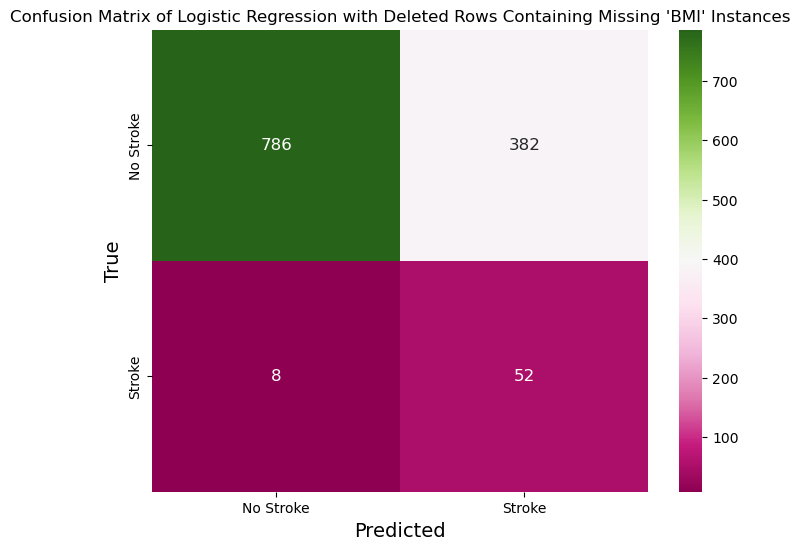

In [85]:
cm = confusion_matrix(y_test, y_pred)
# Visualize confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, cmap="PiYG", fmt="g", annot_kws={"fontsize": 12}, 
           xticklabels=['No Stroke', 'Stroke'], yticklabels=['No Stroke', 'Stroke'])
plt.title("Confusion Matrix of Logistic Regression with Deleted Rows Containing Missing 'BMI' Instances")
plt.xlabel("Predicted", fontsize=14)
plt.ylabel("True", fontsize=14)
plt.show()

## The following codes below retain the mapping of the one-hot-encoded columns, and actually maps back numeric values to their string values (if necessary) to perform further data visualization with the fully filled in df

### Reminder, the two one-hot-encoded columns were: "work_type" and "smoking_status"

In [86]:
# # Retrieve the mapping for "smoking_status" column
# smoking_status_mapping = label_mapping.get('smoking_status', {})

# # Reverse the keys and values in the dictionary
# reversed_smoking_status_mapping = {v: k for k, v in smoking_status_mapping.items()}

# # Retrieve the mapping for "work_type" column
# work_type_mapping = label_mapping.get('work_type', {})

# # Reverse the keys and values in the dictionary
# reversed_work_type_mapping = {v: k for k, v in work_type_mapping.items()}

# print("Smoking Status Mapping:", reversed_smoking_status_mapping)
# print("Work Type Mapping:", reversed_work_type_mapping)

In [87]:
# visual_df = encoded_df.copy()

In [88]:
# ## Use label_mapping to create a new column called "work_type" in new_df

# visual_df['work_type'] = visual_df.apply(lambda row: reversed_work_type_mapping[row[['work_type_0', 'work_type_1', 
#                                                                       'work_type_2', 'work_type_3', 'work_type_4']].values.argmax()], axis=1)

In [89]:
# smoking_status_mapping = {0: 'formerly smoked', 1: 'never smoked', 2: 'smokes', 3: 'Unknown'} 
# # Use mapping to create a new column called "smoking_status" in new_df
# visual_df['smoking_status'] = visual_df.apply(lambda row: reversed_smoking_status_mapping[row[['smoking_status_0', 'smoking_status_1', 'smoking_status_2',
#                                                                                 'smoking_status_3']].values.argmax()], axis=1)


In [90]:
# visual_df

In [91]:
# # Reverse the keys and values in the label_mapping dictionary
# label_mapping

### Convert the label encoded columns back into their string form to be able to perform data visualization

In [92]:
# # Switch keys and values in the label_mapping dictionary to ensure correct decoding of values in visual_df occurs
# reversed_label_mapping = {col: {v: k for k, v in mapping.items()} for col, mapping in label_mapping.items()}

# # Exclude columns "smoking_status" and "work_type"
# exclude_columns = ["smoking_status", "work_type"]

# # Iterate over the label-encoded columns and apply reverse mapping
# for col, mapping in reversed_label_mapping.items():
#     if col not in exclude_columns:
#         # Replace label-encoded values with their original values using the mapping dictionary
#         visual_df[col] = visual_df[col].map(mapping)

# # Now visual_df contains the label-encoded columns (excluding "smoking_status" and "work_type") converted back to their original string values


In [93]:
# visual_df